# LSTM/BiDLSTM Models with Self-embedding Layers

### Import Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

#import metrics and preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,recall_score,confusion_matrix,roc_auc_score,precision_score

#import keras packages
from keras.models import Sequential
from keras.layers import Dense,Embedding,SpatialDropout1D,LSTM,Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import metrics
from keras import optimizers

%matplotlib inline
# import ktrain
import ktrain
from ktrain import text

Using TensorFlow backend.


using Keras version: 2.2.4


### Load Cleaned Files

In [3]:
filepath='Cleaned CSV/'
df=pd.read_csv(filepath+'buzzfeedclean.csv')
test=pd.read_csv(filepath+'snopesclean.csv')

In [4]:
df.head()

,id,url,rating,text,domain,source,lower text,target,nltklemma,spacylemma,spacylemma2,spacy_pos,spacy_pos2
0,1204,http://occupydemocrats.com/2016/09/23/donald-t...,mostly true,"A few days ago, DonaldTrump despicable spawn ...",occupydemocrats.com,buzzfeed,"a few days ago, donaldtrump despicable spawn ...",0,day ago donaldtrump despicable spawn tweeted m...,"day ago , DonaldTrump despicable spawn tweet...","day ago , PROPN despicable spawn tweet meme ...",SPACE NOUN ADV PUNCT PROPN ADJ NOUN VERB NOUN ...,SPACE DET ADJ NOUN ADV PROPN ADJ NOUN VERB ADP...
1,1157,http://occupydemocrats.com/2016/09/19/just-50-...,mostly true,A group of over fifty former intelligence off...,occupydemocrats.com,buzzfeed,a group of over fifty former intelligence off...,0,group fifty former intelligence official natio...,group intelligence official national securit...,group intelligence official national securit...,SPACE NOUN NOUN NOUN ADJ NOUN NOUN VERB NOUN V...,SPACE DET NOUN ADP ADP NUM ADJ NOUN NOUN CCONJ...
2,1165,http://occupydemocrats.com/2016/09/20/proof-tr...,mixture of true and false,A new investigation has determined that Donal...,occupydemocrats.com,buzzfeed,a new investigation has determined that donal...,1,new investigation determined donaldtrump chari...,new investigation determine DonaldTrump char...,new investigation determine PROPN charitable...,SPACE ADJ NOUN VERB PROPN ADJ NOUN VERB ADJ NO...,SPACE DET ADJ NOUN AUX VERB SCONJ PROPN ADJ NO...
3,1199,http://occupydemocrats.com/2016/09/23/breaking...,mostly true,A new video has emerged of the moments before...,occupydemocrats.com,buzzfeed,a new video has emerged of the moments before...,0,new video emerged moment police officer gunned...,new video emerge moment police officer gun K...,new video emerge moment police officer gun P...,SPACE ADJ NOUN VERB NOUN NOUN NOUN VERB PROPN ...,SPACE DET ADJ NOUN AUX VERB ADP DET NOUN ADV C...
4,1210,http://occupydemocrats.com/2016/09/26/wwii-vet...,mostly true,A ninety-six-year-old World War II veteran an...,occupydemocrats.com,buzzfeed,a ninety-six-year-old world war ii veteran an...,0,ninetysixyearold world war ii veteran longtime...,ninety - - year - old World War II veteran l...,ninety - - year - old PROPN PROPN PROPN vete...,SPACE NUM PUNCT PUNCT NOUN PUNCT ADJ PROPN PRO...,SPACE DET NUM NUM NOUN ADJ PROPN PROPN PROPN N...


### Assessment Functions

In [0]:
## Prints a Confusion Matrix with columns and indexes labeled correctly
def printcm(Y,predictions,ground_truth):
    
    columns=pd.get_dummies(Y).columns
    print(columns)
    predictions=pd.DataFrame(predictions)
    predictions[0]=predictions[0].map({n:col for n,col in enumerate(columns)})

    cm=pd.DataFrame(confusion_matrix(ground_truth,predictions[0]),columns=[('Predicted '+str(x)) for x in columns])
    cm['index']=cm['index']=[('Real '+str(x)) for x in columns]
    cm.set_index('index',inplace=True)
    display(cm)

In [0]:
## prints  accuracy,f1,precision,recall scores and the confusion matrix
def assess_model(pred_prob,y_test,threshold):   

    pred_df=pd.DataFrame(pred_prob,columns=['pred_probs'])


    pred_df['true_values']=y_test.values
    pred_df['predict']=pred_df['pred_probs']>threshold
    pred_df['predict']=pred_df['predict'].astype(int)
    predictions=pred_df['predict'].values
    method={}
    
    method['accuracy']=accuracy_score(y_test,predictions)
    method['f']=f1_score(y_test,predictions)
    method['precision']=precision_score(y_test,predictions)
    method['recall']=recall_score(y_test,predictions)
    method['fprate']=FPR(pred_df,'true_values','pred_probs',threshold)
    method['tprate']=TPR(pred_df,'true_values','pred_probs',threshold)
    columns=pd.get_dummies(y_test).columns
    

    printcm(y_test,predictions,y_test.values)
    
    print(method)

    return pred_df

In [0]:
## returns precision and recall at a particular threshold
def custom_pr(true_col,pred_prob_col,threshold,beta=1):
    fbeta=0
    df=pd.DataFrame()
    df['true_col']=true_col
    df['pred_prob_col']=pred_prob_col

    TN = df[(df['true_col'] == 0) & (df['pred_prob_col'] <= threshold)].shape[0]
    FP = df[(df['true_col'] == 0) & (df['pred_prob_col'] > threshold)].shape[0]
    TP = df[(df['true_col'] == 1) & (df['pred_prob_col'] >= threshold)].shape[0]
    FN = df[(df['true_col'] == 1) & (df['pred_prob_col'] < threshold)].shape[0]
    #print(TN,FP,TP,FN)
    
    
    if TP==0:
        precision=0
        recall=0
    else:
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        
    if (precision==0 or recall==0):
        fbeta=0
    else:
        fbeta=(1+beta**2) * (precision * recall) / ((beta**2)*precision + recall)
    return [precision,recall]

In [0]:
# plots a probability distribution of the predictions
def plotprob(pred_df):
# Create figure.
  plt.figure(figsize = (10,7))

# Create two histograms of observations.
  plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
          bins=25,
          color='b',
          alpha = 0.6,
          label='Outcome = 0')
  plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
          bins=25,
          color='orange',
          alpha = 0.6,
          label='Outcome = 1')

# Label axes.
  plt.title('Distribution of P(Outcome = 1)', fontsize=22)
  plt.ylabel('Frequency', fontsize=18)
  plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
  plt.legend(fontsize=20);
  pass

In [0]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

#define function to calculate f1 score for a particular threshold
def f1(df,true_col,pred_prob_col,threshold):
    TN = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    FP = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    TP = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    FN = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    if TP==0:
        precision=0
    else:
        precision=TP/(TP+FP)
        
    recall=TP/(TP+FN)
    if (precision==0 or recall==0):
        f1=0
    else:
        f1=2 * (precision * recall) / (precision + recall)
    return f1

In [0]:
#plots the receiver operating curve
def rocauccurve(pred_df):
  # Create figure.
  plt.figure(figsize = (10,7))
  # Create threshold values. (Dashed red line in image.)
  thresholds = np.linspace(0, 1, 200)
  # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
  tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
  fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

  # Plot ROC curve.
  plt.plot(fpr_values, # False Positive Rate on X-axis
          tpr_values,
          label='ROC Curve')
  # Plot ROC curve.
  plt.plot(thresholds, # False Positive Rate on X-axis
          thresholds,
          label='ROC Curve')
  # Label axes.
  plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
  plt.ylabel('Sensitivity', fontsize=18)
  plt.xlabel('1 - Specificity', fontsize=18)

  # Create legend.
  plt.legend(fontsize=16);

### Neural Network Preprocessing

In [11]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 5000
# This is fixed.
EMBEDDING_DIM = 64


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(np.hstack((df['text'].values,test['text'].values)))
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 40413 unique tokens.


In [12]:
# Turns text into a number sequence where a number represents a word in the corpus dictionary
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1380, 5000)


#### Prepare Target Variables

In [13]:
#Define Target
Y=df['target']
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1380,)


In [0]:
#Dummy the target columns(Not necessary for binary, but necessary for multiclass)
targets=pd.get_dummies(df['target']).columns

In [15]:
df['target'].value_counts(normalize=True).values

array([0.78985507, 0.21014493])

#### Create class weights to counter the difference in class size

In [0]:

counter_weight={}
weights=df['target'].value_counts()
for n,x in enumerate(targets):
  counter_weight[n]=(np.max(weights)/weights[x])
  

In [19]:
counter_weight

{0: 1.0, 1: 3.7586206896551726}

####Train Test Split

In [20]:

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 23,stratify=Y)
Y_train_d=pd.get_dummies(Y_train)
Y_test_d=pd.get_dummies(Y_test)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1104, 5000) (1104,)
(276, 5000) (276,)


### LSTM Model

In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

class_weight = counter_weight




In [0]:
learner = ktrain.get_learner(model,train_data=(X_train, Y_train.values), val_data=(X_test, Y_test.values), batch_size=128,)

In [83]:
history=learner.autofit(0.005,20,early_stopping=2,monitor='val_loss',checkpoint_folder='../Deeplearning Models/LSTM',class_weight=counter_weight)



begin training using triangular learning rate policy with max lr of 0.005...
Train on 1104 samples, validate on 276 samples
Epoch 1/20
1104/1104 [==============================] - 108s 97ms/step - loss: 1.0807 - acc: 0.4475 - val_loss: 0.6671 - val_acc: 0.6486
Epoch 2/20
1104/1104 [==============================] - 107s 97ms/step - loss: 0.9592 - acc: 0.8034 - val_loss: 0.5825 - val_acc: 0.7464
Epoch 3/20
1104/1104 [==============================] - 108s 98ms/step - loss: 0.7343 - acc: 0.8596 - val_loss: 0.5311 - val_acc: 0.7210
Epoch 4/20
1104/1104 [==============================] - 107s 97ms/step - loss: 0.5102 - acc: 0.8995 - val_loss: 0.5211 - val_acc: 0.7065
Epoch 5/20
1104/1104 [==============================] - 108s 97ms/step - loss: 0.3579 - acc: 0.9230 - val_loss: 0.4397 - val_acc: 0.8007
Epoch 6/20
1104/1104 [==============================] - 107s 97ms/step - loss: 0.3327 - acc: 0.9411 - val_loss: 0.5129 - val_acc: 0.7319
Epoch 7/20
1104/1104 [==============================

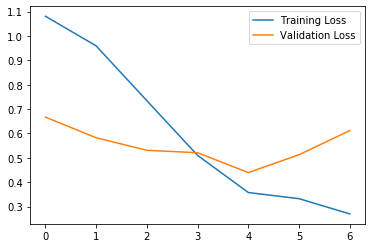

In [84]:
trainingloss=history.history['loss']
testloss=history.history['val_loss']
plt.plot(trainingloss,label='Training Loss')
plt.plot(testloss,label="Validation Loss")
plt.legend()

In [0]:
model.load_weights("../Deeplearning Models/LSTM/weights-05.hdf5")

### Validation Results

In [0]:
LSTM_pred_prob=model.predict(X_test)

In [0]:
LSTM_predictions=model.predict_classes(X_test)

In [28]:
LSTM_pred_df=assess_model(LSTM_pred_prob,Y_test,0.5)

Int64Index([0, 1], dtype='int64')


,Predicted 0,Predicted 1
index,,
Real 0,192,26
Real 1,29,29


{'accuracy': 0.8007246376811594, 'f': 0.5132743362831858, 'precision': 0.5272727272727272, 'recall': 0.5, 'fprate': 0.11926605504587151, 'tprate': 0.5}


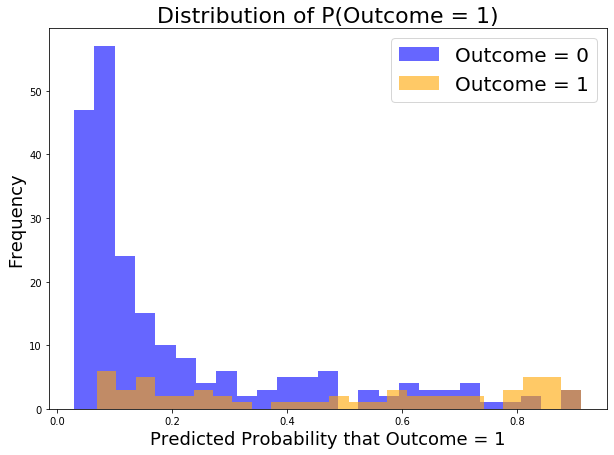

In [29]:
plotprob(LSTM_pred_df)

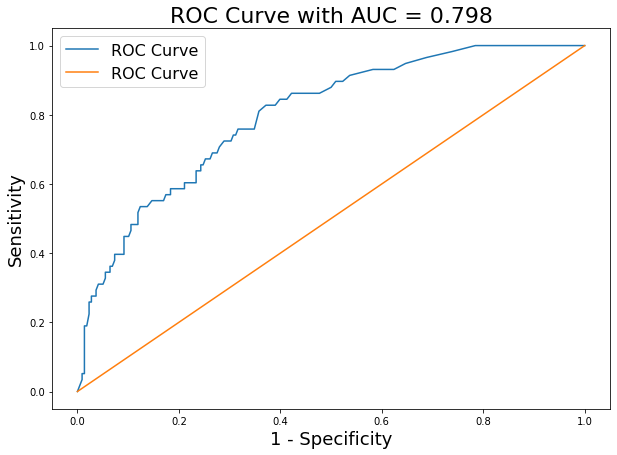

In [30]:
rocauccurve(LSTM_pred_df)

### Bidirectional LSTM

In [0]:
modelbi = Sequential()
modelbi.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
modelbi.add(SpatialDropout1D(0.2))
modelbi.add(Bidirectional(LSTM(8, dropout=0.2, recurrent_dropout=0.2)))
modelbi.add(Dense(1, activation='sigmoid'))

modelbi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])





In [112]:
learner = ktrain.get_learner(modelbi,train_data=(X_train, Y_train.values), val_data=(X_test, Y_test.values), batch_size=128,)

historybi=learner.autofit(0.005,20,early_stopping=2,monitor='val_loss',checkpoint_folder='../Deeplearning Models/BiLSTM',class_weight=counter_weight)



begin training using triangular learning rate policy with max lr of 0.005...
Train on 1104 samples, validate on 276 samples
Epoch 1/20
1104/1104 [==============================] - 222s 201ms/step - loss: 1.0880 - acc: 0.5924 - val_loss: 0.6561 - val_acc: 0.7355
Epoch 2/20
1104/1104 [==============================] - 219s 198ms/step - loss: 0.9567 - acc: 0.8188 - val_loss: 0.5682 - val_acc: 0.7029
Epoch 3/20
1104/1104 [==============================] - 218s 197ms/step - loss: 0.6768 - acc: 0.8487 - val_loss: 0.5420 - val_acc: 0.7101
Epoch 4/20
1104/1104 [==============================] - 220s 199ms/step - loss: 0.4780 - acc: 0.8931 - val_loss: 0.4655 - val_acc: 0.7935
Epoch 5/20
1104/1104 [==============================] - 222s 201ms/step - loss: 0.3682 - acc: 0.9239 - val_loss: 0.5440 - val_acc: 0.7391
Epoch 6/20
1104/1104 [==============================] - 221s 200ms/step - loss: 0.2575 - acc: 0.9357 - val_loss: 0.5350 - val_acc: 0.7536
Restoring model weights from the end of the be

In [1]:
modelbi.load_weights("../Deeplearning Models/BiLSTM/weights-04.hdf5")

NameError: ignored

In [0]:
validation_pred_prob=modelbi.predict(X_test)

In [0]:
validation_predictions=modelbi.predict_classes(X_test)

In [35]:
valid_pred_df=assess_model(validation_pred_prob,Y_test,0.5)

Int64Index([0, 1], dtype='int64')


,Predicted 0,Predicted 1
index,,
Real 0,190,28
Real 1,29,29


{'accuracy': 0.7934782608695652, 'f': 0.5043478260869565, 'precision': 0.5087719298245614, 'recall': 0.5, 'fprate': 0.12844036697247707, 'tprate': 0.5}


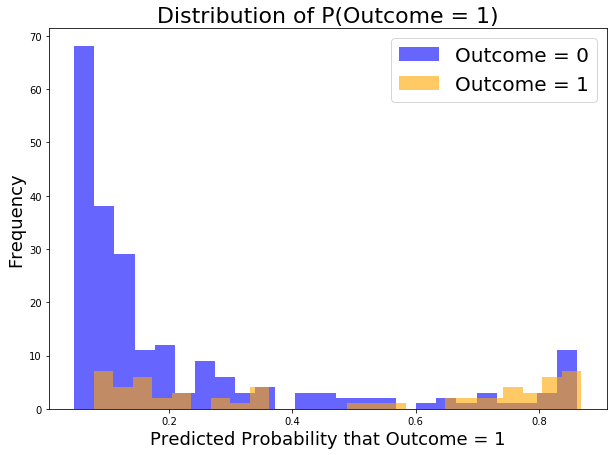

In [36]:
plotprob(valid_pred_df)

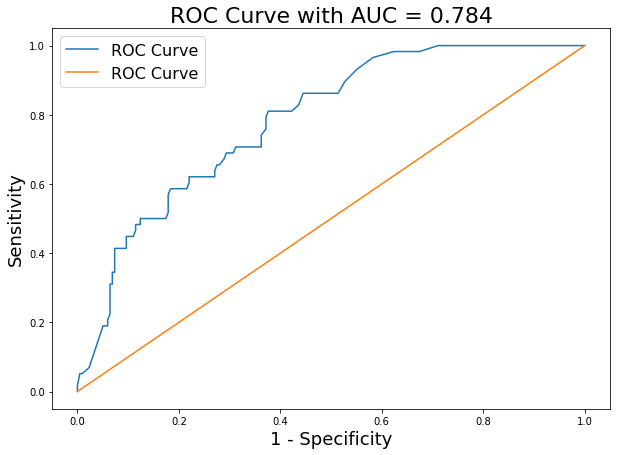

In [37]:
rocauccurve(valid_pred_df)

In [0]:
0.82